# Capital Asset Pricing Model (CAPM)

## Theoretical Foundation

The Capital Asset Pricing Model (CAPM) is a foundational framework in modern portfolio theory that describes the relationship between systematic risk and expected return for assets. Developed independently by William Sharpe (1964), John Lintner (1965), and Jan Mossin (1966), CAPM provides a method for pricing risky securities and generating expected returns for assets given their risk profile.

### The CAPM Equation

The expected return of an asset $i$ is given by:

$$E(R_i) = R_f + \beta_i \left[ E(R_m) - R_f \right]$$

where:
- $E(R_i)$ = Expected return of asset $i$
- $R_f$ = Risk-free rate
- $\beta_i$ = Beta of asset $i$ (systematic risk measure)
- $E(R_m)$ = Expected return of the market portfolio
- $E(R_m) - R_f$ = Market risk premium

### Beta Coefficient

The beta coefficient measures the sensitivity of an asset's returns to market returns:

$$\beta_i = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)} = \frac{\sigma_{i,m}}{\sigma_m^2}$$

where:
- $\sigma_{i,m}$ = Covariance between asset $i$ returns and market returns
- $\sigma_m^2$ = Variance of market returns

### Security Market Line (SML)

The Security Market Line graphically represents the CAPM equation, showing the linear relationship between expected return and beta. Assets plotted above the SML are undervalued (offering excess return for their risk), while those below are overvalued.

### Key Assumptions

1. Investors are rational and risk-averse
2. Markets are frictionless (no taxes or transaction costs)
3. All investors have homogeneous expectations
4. All investors can borrow and lend at the risk-free rate
5. Assets are infinitely divisible
6. Single-period investment horizon

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Define market parameters
risk_free_rate = 0.03  # 3% annual risk-free rate
market_return = 0.10   # 10% expected market return
market_volatility = 0.20  # 20% market volatility
n_periods = 252  # Trading days in a year
n_assets = 10    # Number of assets to simulate

print("Market Parameters:")
print(f"Risk-free rate: {risk_free_rate:.1%}")
print(f"Expected market return: {market_return:.1%}")
print(f"Market volatility: {market_volatility:.1%}")

Market Parameters:
Risk-free rate: 3.0%
Expected market return: 10.0%
Market volatility: 20.0%


## Simulating Market and Asset Returns

We generate synthetic return data for the market portfolio and individual assets with varying beta exposures. The returns follow a factor model structure:

$$R_i = \alpha_i + \beta_i R_m + \epsilon_i$$

where $\epsilon_i \sim N(0, \sigma_{\epsilon}^2)$ represents idiosyncratic risk.

In [2]:
# Generate market returns
daily_market_return = market_return / n_periods
daily_market_vol = market_volatility / np.sqrt(n_periods)

market_returns = np.random.normal(daily_market_return, daily_market_vol, n_periods)

# Define true betas for assets (ranging from defensive to aggressive)
true_betas = np.array([0.5, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.5, 1.8])
asset_names = [f'Asset_{i+1}' for i in range(n_assets)]

# Define true alphas (most assets have zero alpha in efficient markets)
true_alphas = np.array([0.001, -0.0005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, -0.001, 0.0015]) / n_periods

# Generate asset returns with idiosyncratic risk
idiosyncratic_vol = 0.15 / np.sqrt(n_periods)  # 15% annual idiosyncratic volatility

asset_returns = np.zeros((n_periods, n_assets))
for i in range(n_assets):
    epsilon = np.random.normal(0, idiosyncratic_vol, n_periods)
    asset_returns[:, i] = true_alphas[i] + true_betas[i] * market_returns + epsilon

# Create DataFrame
returns_df = pd.DataFrame(asset_returns, columns=asset_names)
returns_df['Market'] = market_returns

print("Simulated Returns Summary Statistics:")
print(returns_df.describe().round(4))

Simulated Returns Summary Statistics:
        Asset_1   Asset_2   Asset_3   Asset_4   Asset_5   Asset_6   Asset_7  \
count  252.0000  252.0000  252.0000  252.0000  252.0000  252.0000  252.0000   
mean     0.0004   -0.0005    0.0017    0.0012    0.0013    0.0011    0.0001   
std      0.0114    0.0133    0.0132    0.0154    0.0154    0.0163    0.0168   
min     -0.0333   -0.0394   -0.0414   -0.0324   -0.0425   -0.0547   -0.0394   
25%     -0.0071   -0.0098   -0.0060   -0.0094   -0.0087   -0.0105   -0.0122   
50%      0.0001    0.0006   -0.0000    0.0000    0.0002    0.0011    0.0008   
75%      0.0076    0.0074    0.0094    0.0122    0.0113    0.0126    0.0119   
max      0.0297    0.0380    0.0528    0.0467    0.0531    0.0514    0.0606   

        Asset_8   Asset_9  Asset_10    Market  
count  252.0000  252.0000  252.0000  252.0000  
mean     0.0002    0.0007    0.0016    0.0003  
std      0.0193    0.0200    0.0233    0.0122  
min     -0.0464   -0.0528   -0.0513   -0.0326  
25%     -0

## Beta Estimation via OLS Regression

We estimate beta coefficients using Ordinary Least Squares regression of asset returns on market returns:

$$\hat{\beta}_i = \frac{\sum_{t=1}^{T}(R_{i,t} - \bar{R}_i)(R_{m,t} - \bar{R}_m)}{\sum_{t=1}^{T}(R_{m,t} - \bar{R}_m)^2}$$

In [3]:
def estimate_capm_parameters(asset_returns, market_returns):
    """
    Estimate CAPM parameters using OLS regression.
    
    Parameters:
    -----------
    asset_returns : array-like
        Time series of asset returns
    market_returns : array-like
        Time series of market returns
    
    Returns:
    --------
    dict : Contains alpha, beta, r_squared, and standard errors
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(market_returns, asset_returns)
    
    return {
        'alpha': intercept,
        'beta': slope,
        'r_squared': r_value**2,
        'beta_std_err': std_err,
        'p_value': p_value
    }

# Estimate parameters for all assets
estimated_params = []
for i in range(n_assets):
    params = estimate_capm_parameters(asset_returns[:, i], market_returns)
    params['asset'] = asset_names[i]
    params['true_beta'] = true_betas[i]
    params['true_alpha'] = true_alphas[i] * n_periods  # Annualize
    estimated_params.append(params)

params_df = pd.DataFrame(estimated_params)
params_df['alpha_annual'] = params_df['alpha'] * n_periods  # Annualize alpha

print("\nCAPM Parameter Estimates:")
print(params_df[['asset', 'true_beta', 'beta', 'beta_std_err', 'r_squared']].round(4).to_string(index=False))


CAPM Parameter Estimates:
   asset  true_beta   beta  beta_std_err  r_squared
 Asset_1        0.5 0.5172        0.0492     0.3069
 Asset_2        0.7 0.7725        0.0486     0.5021
 Asset_3        0.8 0.8074        0.0459     0.5532
 Asset_4        0.9 0.9769        0.0505     0.5993
 Asset_5        1.0 1.0104        0.0482     0.6370
 Asset_6        1.1 1.0877        0.0493     0.6606
 Asset_7        1.2 1.1595        0.0473     0.7065
 Asset_8        1.3 1.3877        0.0485     0.7661
 Asset_9        1.5 1.4721        0.0462     0.8027
Asset_10        1.8 1.7537        0.0481     0.8417


## Expected Returns and the Security Market Line

Using the estimated betas, we compute expected returns according to CAPM and compare them with realized returns to identify potential mispricings.

In [4]:
# Calculate expected returns using CAPM
market_risk_premium = market_return - risk_free_rate

params_df['expected_return'] = risk_free_rate + params_df['beta'] * market_risk_premium
params_df['realized_return'] = returns_df[asset_names].mean().values * n_periods
params_df['abnormal_return'] = params_df['realized_return'] - params_df['expected_return']

print("\nExpected vs Realized Returns:")
print(params_df[['asset', 'beta', 'expected_return', 'realized_return', 'abnormal_return']].round(4).to_string(index=False))


Expected vs Realized Returns:
   asset   beta  expected_return  realized_return  abnormal_return
 Asset_1 0.5172           0.0662           0.1052           0.0390
 Asset_2 0.7725           0.0841          -0.1217          -0.2058
 Asset_3 0.8074           0.0865           0.4259           0.3394
 Asset_4 0.9769           0.0984           0.3092           0.2108
 Asset_5 1.0104           0.1007           0.3357           0.2350
 Asset_6 1.0877           0.1061           0.2664           0.1602
 Asset_7 1.1595           0.1112           0.0275          -0.0837
 Asset_8 1.3877           0.1271           0.0581          -0.0690
 Asset_9 1.4721           0.1330           0.1783           0.0453
Asset_10 1.7537           0.1528           0.3935           0.2407


## Visualization: Security Market Line

The Security Market Line (SML) plots expected return against beta, with the slope equal to the market risk premium.

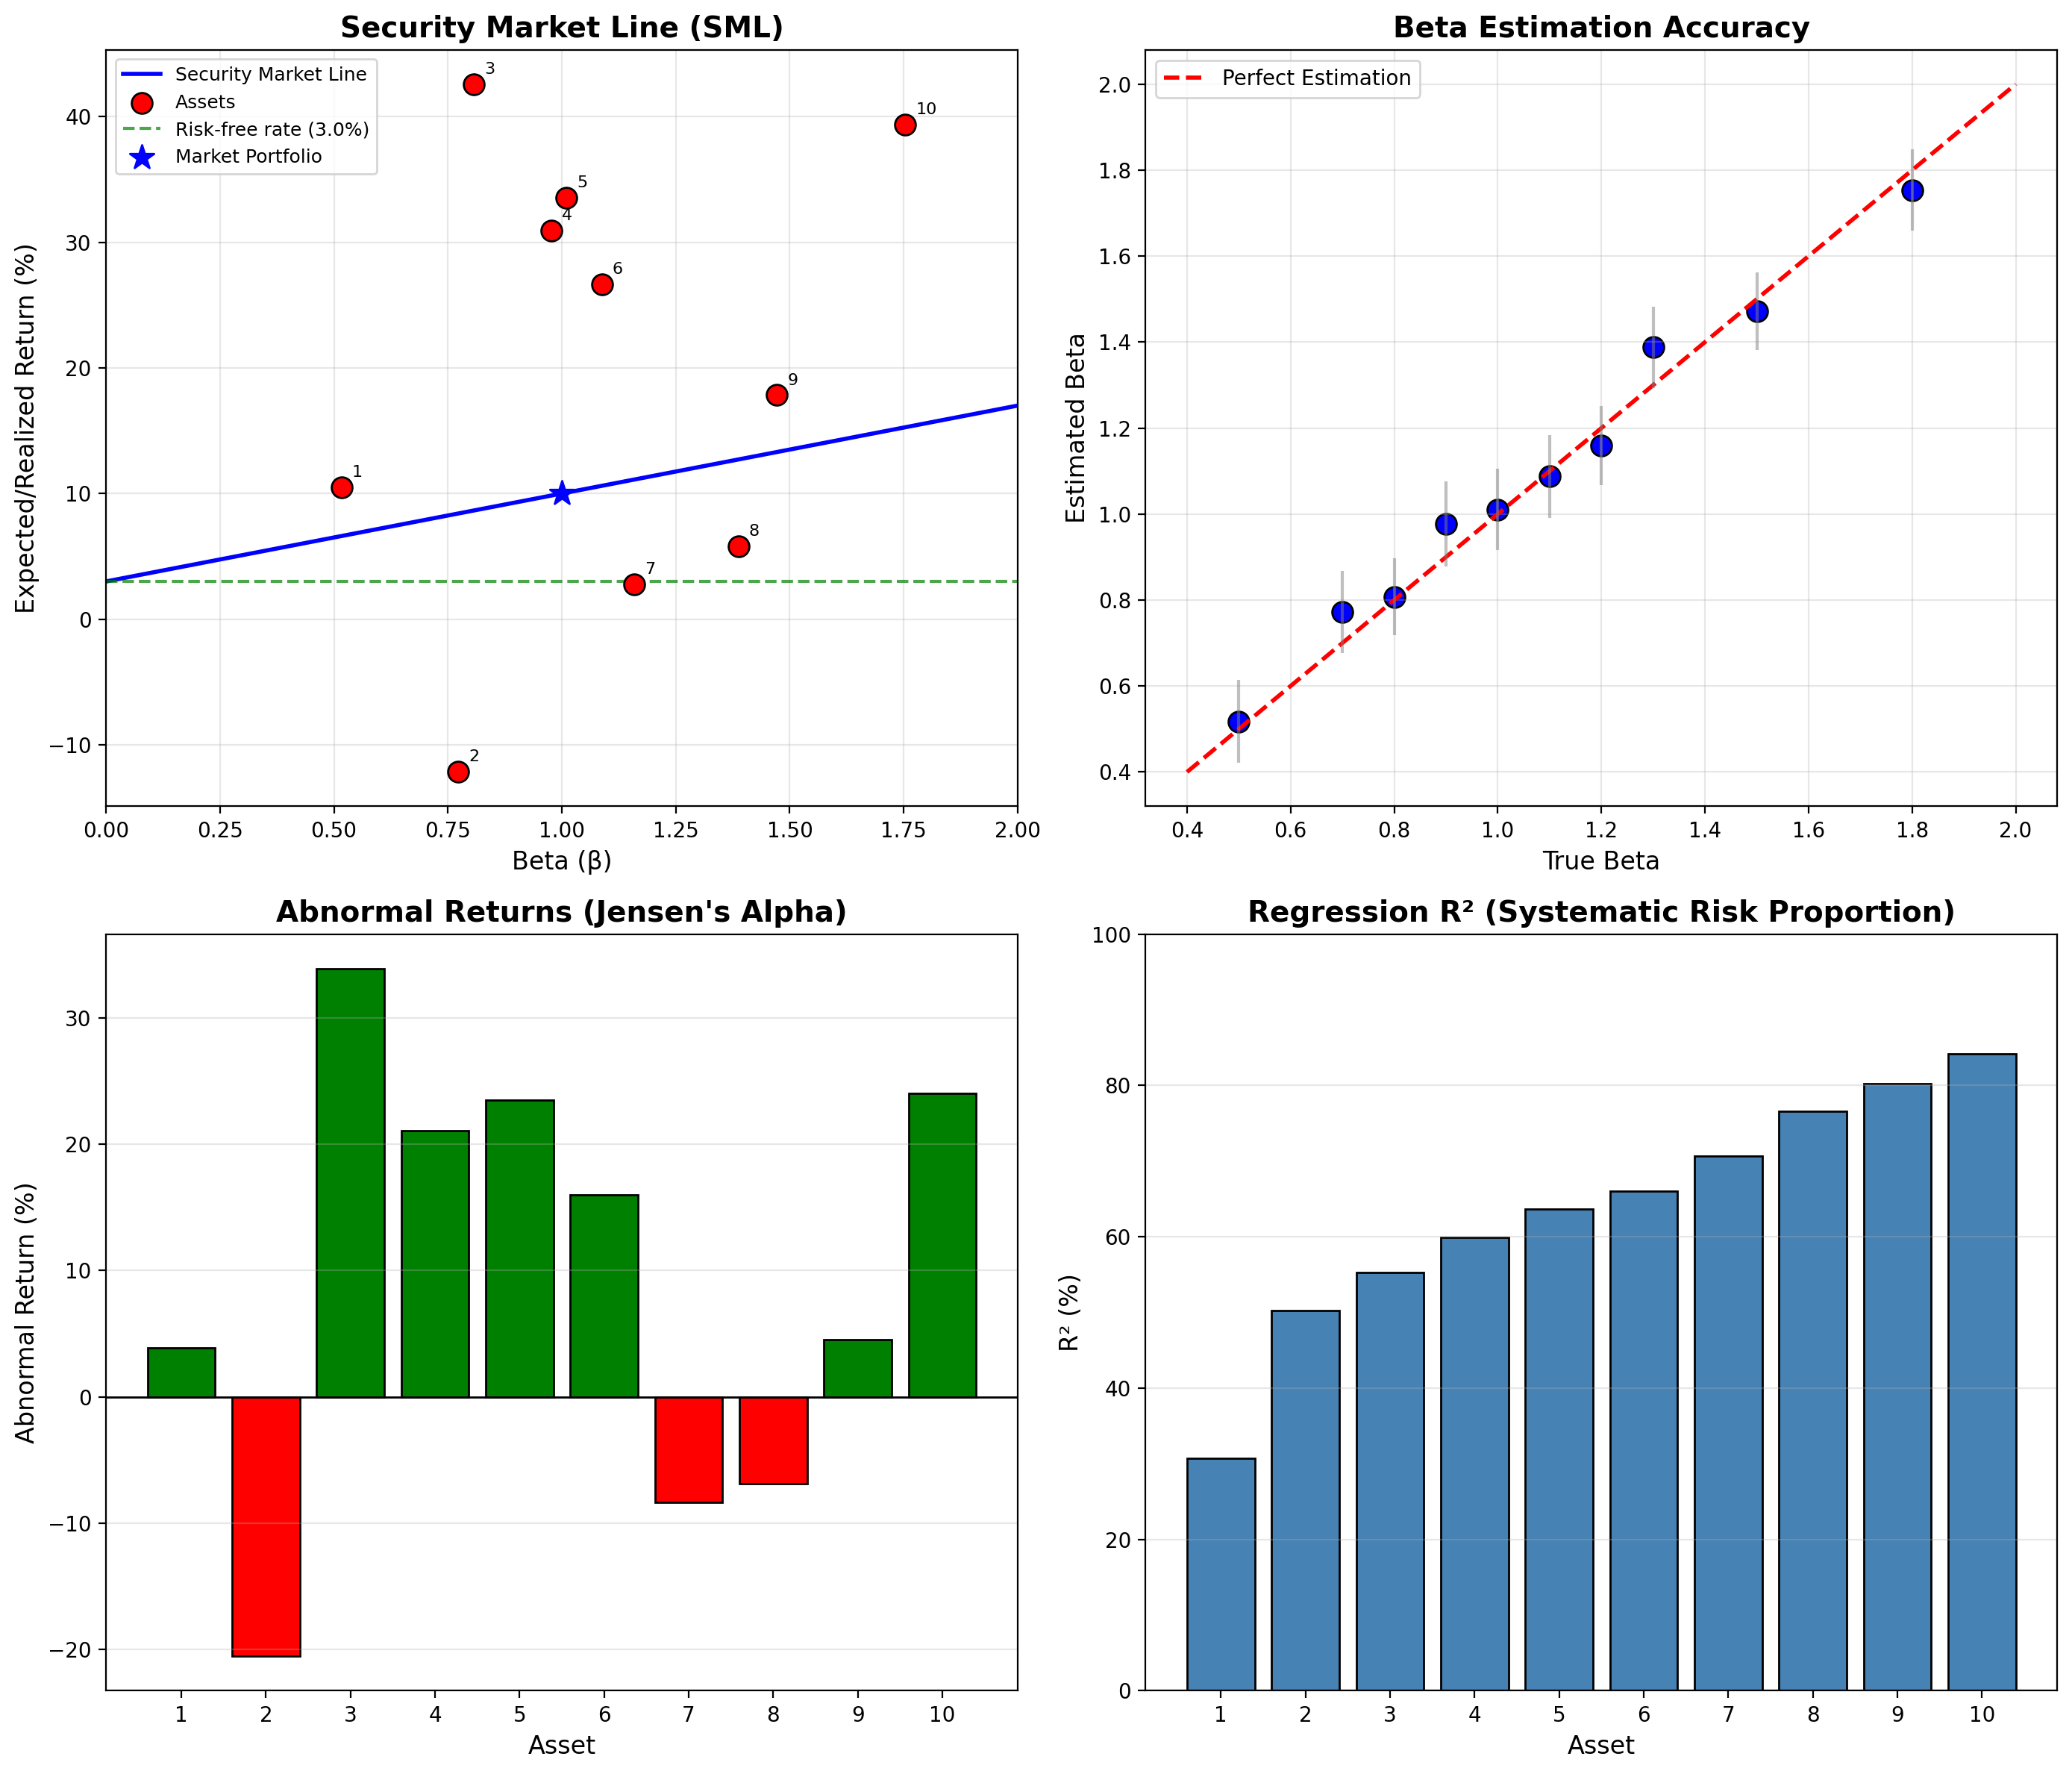


Plot saved to 'plot.png'


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Security Market Line
ax1 = axes[0, 0]
beta_range = np.linspace(0, 2, 100)
sml_returns = risk_free_rate + beta_range * market_risk_premium

ax1.plot(beta_range, sml_returns * 100, 'b-', linewidth=2, label='Security Market Line')
ax1.scatter(params_df['beta'], params_df['realized_return'] * 100, 
            c='red', s=100, edgecolors='black', zorder=5, label='Assets')

# Add asset labels
for idx, row in params_df.iterrows():
    ax1.annotate(row['asset'].split('_')[1], 
                 (row['beta'], row['realized_return'] * 100),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.axhline(y=risk_free_rate * 100, color='green', linestyle='--', alpha=0.7, label=f'Risk-free rate ({risk_free_rate:.1%})')
ax1.scatter([1], [market_return * 100], c='blue', s=150, marker='*', zorder=6, label='Market Portfolio')

ax1.set_xlabel('Beta (β)', fontsize=12)
ax1.set_ylabel('Expected/Realized Return (%)', fontsize=12)
ax1.set_title('Security Market Line (SML)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2)

# Plot 2: Beta Estimation Accuracy
ax2 = axes[0, 1]
ax2.scatter(params_df['true_beta'], params_df['beta'], c='blue', s=100, edgecolors='black')
ax2.plot([0.4, 2], [0.4, 2], 'r--', linewidth=2, label='Perfect Estimation')
ax2.errorbar(params_df['true_beta'], params_df['beta'], 
             yerr=1.96 * params_df['beta_std_err'], fmt='none', ecolor='gray', alpha=0.5)

ax2.set_xlabel('True Beta', fontsize=12)
ax2.set_ylabel('Estimated Beta', fontsize=12)
ax2.set_title('Beta Estimation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Abnormal Returns (Alpha)
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in params_df['abnormal_return']]
bars = ax3.bar(params_df['asset'].str.replace('Asset_', ''), 
               params_df['abnormal_return'] * 100, color=colors, edgecolor='black')
ax3.axhline(y=0, color='black', linewidth=1)
ax3.set_xlabel('Asset', fontsize=12)
ax3.set_ylabel('Abnormal Return (%)', fontsize=12)
ax3.set_title('Abnormal Returns (Jensen\'s Alpha)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: R-squared values
ax4 = axes[1, 1]
ax4.bar(params_df['asset'].str.replace('Asset_', ''), 
        params_df['r_squared'] * 100, color='steelblue', edgecolor='black')
ax4.set_xlabel('Asset', fontsize=12)
ax4.set_ylabel('R² (%)', fontsize=12)
ax4.set_title('Regression R² (Systematic Risk Proportion)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('capm_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Portfolio Beta and Expected Return

For a portfolio of $n$ assets with weights $w_i$, the portfolio beta is:

$$\beta_p = \sum_{i=1}^{n} w_i \beta_i$$

And the expected portfolio return follows:

$$E(R_p) = R_f + \beta_p \left[ E(R_m) - R_f \right]$$

In [6]:
# Create sample portfolios with different risk profiles
portfolios = {
    'Conservative': np.array([0.3, 0.25, 0.2, 0.15, 0.1, 0, 0, 0, 0, 0]),
    'Balanced': np.array([0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0, 0]),
    'Aggressive': np.array([0, 0, 0, 0, 0.1, 0.15, 0.2, 0.25, 0.2, 0.1])
}

print("\nPortfolio Analysis:")
print("=" * 60)

for name, weights in portfolios.items():
    portfolio_beta = np.sum(weights * params_df['beta'])
    expected_return = risk_free_rate + portfolio_beta * market_risk_premium
    realized_return = np.sum(weights * params_df['realized_return'])
    
    print(f"\n{name} Portfolio:")
    print(f"  Portfolio Beta: {portfolio_beta:.3f}")
    print(f"  Expected Return: {expected_return:.2%}")
    print(f"  Realized Return: {realized_return:.2%}")
    print(f"  Risk Premium: {(expected_return - risk_free_rate):.2%}")


Portfolio Analysis:

Conservative Portfolio:
  Portfolio Beta: 0.757
  Expected Return: 8.30%
  Realized Return: 16.63%
  Risk Premium: 5.30%

Balanced Portfolio:
  Portfolio Beta: 0.982
  Expected Return: 9.87%
  Realized Return: 20.08%
  Risk Premium: 6.87%

Aggressive Portfolio:
  Portfolio Beta: 1.313
  Expected Return: 12.19%
  Realized Return: 16.86%
  Risk Premium: 9.19%


## Limitations and Extensions

### CAPM Limitations
1. **Single-factor model**: Only considers market risk, ignoring size, value, momentum factors
2. **Unrealistic assumptions**: Perfect markets, homogeneous expectations
3. **Static beta**: Assumes constant risk exposure over time
4. **Empirical challenges**: Low-beta anomaly, beta instability

### Modern Extensions
- **Fama-French Three-Factor Model**: Adds size (SMB) and value (HML) factors
- **Carhart Four-Factor Model**: Adds momentum factor
- **Fama-French Five-Factor Model**: Adds profitability and investment factors
- **Conditional CAPM**: Time-varying betas based on economic conditions

### Applications
- **Cost of equity estimation** for corporate finance
- **Performance attribution** and benchmark comparison
- **Risk management** and portfolio construction

In [7]:
# Summary statistics
print("\n" + "=" * 60)
print("CAPM ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nMarket Parameters:")
print(f"  Risk-free rate: {risk_free_rate:.2%}")
print(f"  Expected market return: {market_return:.2%}")
print(f"  Market risk premium: {market_risk_premium:.2%}")
print(f"\nEstimation Quality:")
print(f"  Average R²: {params_df['r_squared'].mean():.2%}")
print(f"  Beta estimation RMSE: {np.sqrt(((params_df['beta'] - params_df['true_beta'])**2).mean()):.4f}")
print(f"\nAsset Range:")
print(f"  Beta range: [{params_df['beta'].min():.2f}, {params_df['beta'].max():.2f}]")
print(f"  Expected return range: [{params_df['expected_return'].min():.2%}, {params_df['expected_return'].max():.2%}]")


CAPM ANALYSIS SUMMARY

Market Parameters:
  Risk-free rate: 3.00%
  Expected market return: 10.00%
  Market risk premium: 7.00%

Estimation Quality:
  Average R²: 63.76%
  Beta estimation RMSE: 0.0490

Asset Range:
  Beta range: [0.52, 1.75]
  Expected return range: [6.62%, 15.28%]
